In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
# list cuda devices
print("Available CUDA devices:")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Available CUDA devices:
Device 0: NVIDIA RTX A5500


In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)

mnist_img_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_images_easy-train.npy"
mnist_lbls_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_labels_easy-train.npy"
mnist_img_train = np.load(mnist_img_train_path, allow_pickle=True)
mnist_lbls_train = np.load(mnist_lbls_train_path, allow_pickle=True)

mnist_img_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_images_easy-validation.npy"
mnist_lbls_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_labels_easy-validation.npy"
mnist_img_val = np.load(mnist_img_val_path, allow_pickle=True)
mnist_lbls_val = np.load(mnist_lbls_val_path, allow_pickle=True)


## Pretrain convolution filters on MNIST characters

In [27]:
# Create dataset for MNIST characters
class MNIST_Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx][np.newaxis,:,:]
        label = self.labels[idx]
        return image, label

In [28]:
# Create datasets
mnist_train_ds = MNIST_Dataset(mnist_img_train, mnist_lbls_train)
mnist_val_ds = MNIST_Dataset(mnist_img_val, mnist_lbls_val)


In [32]:
class MNIST_Classifier(nn.Module):
    def __init__(self, device='cuda'):
        super(MNIST_Classifier, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.model()
        self.to(self.device)
        
    def model(self):
        self.mdl = nn.Sequential(
            self.conv1,
            self.mp1,
            self.bnorm1,
            nn.ReLU(),
            self.conv2,
            self.mp2,
            self.bnorm2,
            nn.ReLU(),
            nn.Flatten(),
            self.fc1,
            self.dropout,
            self.fc2
        )

    def forward(self, x):
        x = self.mdl(x)
        return x

In [34]:
mdl = MNIST_Classifier()

optim = torch.optim.Adam(mdl.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

epoch_num = 100

train_dl = DataLoader(mnist_train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(mnist_val_ds, batch_size=1024, shuffle=True)

for i in range(epoch_num):
    mdl.train()
    for imgs, lbls in train_dl:
        imgs, lbls = imgs.to(mdl.device).float(), lbls.to(mdl.device).long()
        optim.zero_grad()
        preds = mdl(imgs)
        loss = loss_fn(preds, lbls)
        loss.backward()
        optim.step()
    
    mdl.eval()
    with torch.no_grad():
        imgs, lbls = next(iter(val_dl))
        imgs, lbls = imgs.to(mdl.device).float(), lbls.to(mdl.device).long()
        preds = mdl(imgs)
        acc = (preds.argmax(dim=1) == lbls).float().mean() * 100
        print(f"Validation Accuracy: {acc.item():.2f}%")


Validation Accuracy: 96.58%
Validation Accuracy: 97.95%
Validation Accuracy: 99.12%
Validation Accuracy: 98.93%
Validation Accuracy: 98.73%
Validation Accuracy: 98.44%
Validation Accuracy: 98.73%
Validation Accuracy: 98.93%
Validation Accuracy: 97.46%
Validation Accuracy: 98.73%
Validation Accuracy: 98.54%
Validation Accuracy: 98.54%
Validation Accuracy: 98.54%
Validation Accuracy: 98.83%
Validation Accuracy: 99.02%
Validation Accuracy: 99.12%
Validation Accuracy: 98.73%
Validation Accuracy: 98.44%
Validation Accuracy: 98.73%
Validation Accuracy: 98.54%
Validation Accuracy: 98.63%
Validation Accuracy: 98.93%
Validation Accuracy: 98.73%
Validation Accuracy: 98.54%
Validation Accuracy: 98.34%
Validation Accuracy: 99.02%
Validation Accuracy: 98.14%
Validation Accuracy: 98.93%
Validation Accuracy: 99.41%
Validation Accuracy: 99.32%
Validation Accuracy: 99.22%
Validation Accuracy: 98.63%
Validation Accuracy: 98.34%
Validation Accuracy: 98.93%
Validation Accuracy: 98.34%
Validation Accuracy:

In [3]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of purely feedforward models
class MC_FF_Dataset(Dataset):
    def __init__(self, data, labels, stack_size=3):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): Array of shape (num_samples,) with labels
            stack_size (int): Number of frames to stack for input as multichannel image
        """

        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.stack_size = stack_size

    def __len__(self):
        return self.data.shape[0] - self.stack_size + 1

    def __getitem__(self, idx):
        # Stack frames to create a multichannel image
        stacked_frames = self.data[idx:(idx + self.stack_size)].astype(np.float32)
        labels = self.labels[idx + self.stack_size - 1]
        return stacked_frames, labels


In [5]:
train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=3)
val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=3)

In [6]:
ind=30

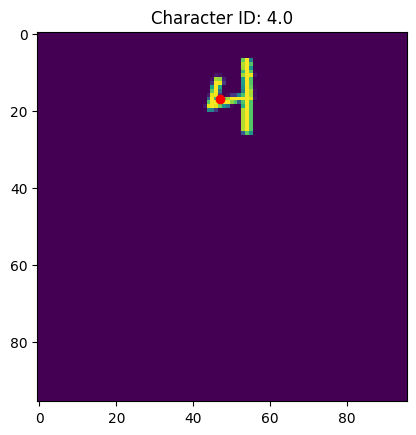

In [7]:
s,l=train_ds[ind]
plt.imshow(s[0, :, :])
plt.scatter(l[1], l[2], c='r')
plt.title(f'Character ID: {l[0]}')
ind+=1

In [13]:
class FeedForwardConv(nn.Module):
    def __init__(self, input_channels, num_classes, num_pos, mnist_pre=None, kernel_size=3, device='cuda'):
        super(FeedForwardConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding='same')
        if mnist_pre is not None:
            # set weights of self.conv1 to mnist_pre.conv1
            self.conv1.weight.data = torch.cat([torch.zeros(mnist_pre.conv1.weight.shape).to(self.device), 
                                                  torch.zeros(mnist_pre.conv1.weight.shape).to(self.device),
                                                  mnist_pre.conv1.weight], dim=1)
            self.conv1.bias.data = mnist_pre.conv1.bias.data
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        if mnist_pre is not None:
            # set weights of self.conv2 to mnist_pre.conv2
            self.conv2.weight.data = mnist_pre.conv2.weight
            self.conv2.bias.data = mnist_pre.conv2.bias.data
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.5)
        self.fcchar = nn.Linear(512, num_classes)
        self.fcpos = nn.Linear(512, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        return nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.dropout
        )(x)

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)

        x = x.view(x.size(0), -1)
        x = self.middle(x)

        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [ ]:
# train feedforward network
def network_train(mdl, train_data, val_data, num_epochs=50, loss_weights=[1, 0.01]):
    optim = torch.optim.Adam(mdl.parameters(), lr=0.001)

    # Define loss functions
    criterion_char = nn.CrossEntropyLoss()
    criterion_pos = nn.MSELoss()

    # data loader
    train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_data, batch_size=512, shuffle=True)
    train_acc_char = np.zeros(num_epochs)
    val_acc_char = np.zeros(num_epochs)
    train_err_pos = np.zeros(num_epochs)
    val_err_pos = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        mdl.train()
        for batch in train_dl:
            inputs, labels = batch
            labels = labels.to(mdl.device)
            labels_char = labels[:, 0].long()
            labels_pos = labels[:, 1:].float()

            optim.zero_grad()
            out_char, out_pos = mdl(inputs)
            loss_char = criterion_char(out_char, labels_char)
            loss_pos = criterion_pos(out_pos, labels_pos)
            loss = loss_weights[0]*loss_char + loss_weights[1]*loss_pos
            loss.backward()
            optim.step()
            train_acc_char[epoch] += (torch.argmax(out_char, dim=1) == labels_char).float().sum().item()
            train_err_pos[epoch] += F.mse_loss(out_pos, labels_pos, reduction='sum').item()

        train_acc_char[epoch] /= len(train_data)
        train_acc_char[epoch] *= 100  # Convert to percentage
        train_err_pos[epoch] /= len(train_data)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_acc_char[epoch]:.2f}%, Train Position Error: {train_err_pos[epoch]:.2f} pix^2")

        # Print accuracy on character id for validation data
        with torch.no_grad():
            val_in, val_lbls = next(iter(val_dl))
            val_lbls = val_lbls.to(mdl.device)
            val_out_char, val_out_pos = mdl(val_in)
            val_pred_char = torch.argmax(val_out_char, dim=1).to(mdl.device)
            val_acc_char[epoch] = (val_pred_char == val_lbls[:, 0].long()).float().mean()*100
            val_err_pos[epoch] = F.mse_loss(val_out_pos, val_lbls[:, 1:].float(), reduction='mean')
            print(f"Validation: Digit accuracy - {val_acc_char[epoch]:.2f}%, Position error - {val_err_pos[epoch]:.2f} pix^2")

    torch.cuda.empty_cache()

    return {
        "train_acc_char": train_acc_char,
        "val_acc_char": val_acc_char,
        "train_err_pos": train_err_pos,
        "val_err_pos": val_err_pos,
        "model": mdl.to("cpu")
    }

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_reg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_reg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 33.62%, Train Position Error: 300.50 pix^2
Validation: Digit accuracy - 51.56%, Position error - 116.05 pix^2
Epoch 2/20, Train Accuracy: 61.75%, Train Position Error: 232.76 pix^2
Validation: Digit accuracy - 63.28%, Position error - 119.99 pix^2
Epoch 3/20, Train Accuracy: 71.07%, Train Position Error: 209.12 pix^2
Validation: Digit accuracy - 57.42%, Position error - 126.04 pix^2
Epoch 4/20, Train Accuracy: 76.00%, Train Position Error: 193.07 pix^2
Validation: Digit accuracy - 59.96%, Position error - 120.05 pix^2
Epoch 5/20, Train Accuracy: 79.35%, Train Position Error: 180.73 pix^2
Validation: Digit accuracy - 59.18%, Position error - 119.62 pix^2
Epoch 6/20, Train Accuracy: 81.60%, Train Position Error: 170.66 pix^2
Validation: Digit accuracy - 59.38%, Position error - 135.20 pix^2
Epoch 7/20, Train Accuracy: 83.36%, Train Position Error: 162.79 pix^2
Validation: Digit accuracy - 60.55%, Position error - 118.44 pix^2
Epoch 

## One background character

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_1bg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 46.82%, Train Position Error: 201.13 pix^2
Validation: Digit accuracy - 37.67%, Position error - 281.28 pix^2
Epoch 2/20, Train Accuracy: 73.05%, Train Position Error: 149.63 pix^2
Validation: Digit accuracy - 37.82%, Position error - 278.33 pix^2
Epoch 3/20, Train Accuracy: 79.26%, Train Position Error: 130.65 pix^2
Validation: Digit accuracy - 40.99%, Position error - 287.42 pix^2
Epoch 4/20, Train Accuracy: 82.56%, Train Position Error: 118.70 pix^2
Validation: Digit accuracy - 38.55%, Position error - 299.18 pix^2
Epoch 5/20, Train Accuracy: 84.67%, Train Position Error: 110.18 pix^2
Validation: Digit accuracy - 41.65%, Position error - 276.86 pix^2
Epoch 6/20, Train Accuracy: 86.23%, Train Position Error: 102.69 pix^2
Validation: Digit accuracy - 40.19%, Position error - 285.65 pix^2
Epoch 7/20, Train Accuracy: 87.49%, Train Position Error: 96.46 pix^2
Validation: Digit accuracy - 40.45%, Position error - 265.57 pix^2
Epoch 8

KeyboardInterrupt: 

## Foreground and background character have same slow speed (1 pix)

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_1bg1s_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))

Training with stack size: 3


KeyboardInterrupt: 

## Foreground and background character have same slow speed (1 pix), only training on one factor at a time

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff_pos = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg1s_ff_pos.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20, loss_weights=[0, 0.01]))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 9.81%, Train Position Error: 204.46 pix^2
Validation: Digit accuracy - 10.47%, Position error - 97.88 pix^2
Epoch 2/20, Train Accuracy: 9.82%, Train Position Error: 165.50 pix^2
Validation: Digit accuracy - 11.11%, Position error - 88.79 pix^2
Epoch 3/20, Train Accuracy: 9.80%, Train Position Error: 152.97 pix^2
Validation: Digit accuracy - 10.62%, Position error - 96.53 pix^2
Epoch 4/20, Train Accuracy: 9.82%, Train Position Error: 144.46 pix^2
Validation: Digit accuracy - 10.25%, Position error - 88.93 pix^2
Epoch 5/20, Train Accuracy: 9.85%, Train Position Error: 137.08 pix^2
Validation: Digit accuracy - 10.86%, Position error - 90.99 pix^2
Epoch 6/20, Train Accuracy: 9.84%, Train Position Error: 131.82 pix^2
Validation: Digit accuracy - 10.35%, Position error - 93.88 pix^2
Epoch 7/20, Train Accuracy: 9.81%, Train Position Error: 126.58 pix^2
Validation: Digit accuracy - 10.47%, Position error - 87.48 pix^2
Epoch 8/20, Train Ac

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff_char = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg1s_ff_char.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20, loss_weights=[1.0, 0.0]))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 64.64%, Train Position Error: 5357.91 pix^2
Validation: Digit accuracy - 62.65%, Position error - 2643.72 pix^2
Epoch 2/20, Train Accuracy: 86.10%, Train Position Error: 5357.12 pix^2
Validation: Digit accuracy - 63.23%, Position error - 2703.94 pix^2
Epoch 3/20, Train Accuracy: 90.98%, Train Position Error: 5356.95 pix^2
Validation: Digit accuracy - 61.69%, Position error - 2684.29 pix^2


KeyboardInterrupt: 

## Vary foreground and background character speeds

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [1, 2, 4, 8, 16]
results_1bg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=50))

Training with stack size: 1
Epoch 1/50, Train Accuracy: 48.61%, Train Position Error: 421.72 pix^2
Validation: Digit accuracy - 45.56%, Position error - 222.14 pix^2
Epoch 2/50, Train Accuracy: 69.35%, Train Position Error: 350.92 pix^2
Validation: Digit accuracy - 47.63%, Position error - 236.55 pix^2
Epoch 3/50, Train Accuracy: 80.67%, Train Position Error: 264.08 pix^2
Validation: Digit accuracy - 47.00%, Position error - 264.74 pix^2
Epoch 4/50, Train Accuracy: 87.21%, Train Position Error: 196.05 pix^2
Validation: Digit accuracy - 48.54%, Position error - 264.82 pix^2
Epoch 5/50, Train Accuracy: 90.86%, Train Position Error: 154.25 pix^2
Validation: Digit accuracy - 46.53%, Position error - 274.98 pix^2
Epoch 6/50, Train Accuracy: 93.17%, Train Position Error: 128.55 pix^2
Validation: Digit accuracy - 47.51%, Position error - 266.84 pix^2
Epoch 7/50, Train Accuracy: 94.51%, Train Position Error: 111.60 pix^2
Validation: Digit accuracy - 46.00%, Position error - 272.08 pix^2
Epoch 

KeyboardInterrupt: 

In [ ]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of RNN models
class MC_RNN_Dataset(Dataset):
    def __init__(self, data, labels, frame_num=3):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): Array of shape (num_samples,) with labels
            frame_num (int): Number of frames to stack for input as multichannel image
        """

        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.frame_num = frame_num

    def __len__(self):
        return self.data.shape[0] - self.frame_num + 1

    def __getitem__(self, idx):
        # Stack frames to create a multichannel image
        stacked_frames = self.data[idx:(idx + self.frame_num)].astype(np.float32)
        # insert channel dimension
        stacked_frames = np.expand_dims(stacked_frames, axis=1)
        labels = self.labels[idx:(idx + self.frame_num)]
        return stacked_frames, labels


In [ ]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConv(nn.Module):
    def __init__(self, num_classes, num_pos, mnist_pre=None, kernel_size=3, device='cuda'):
        super(RNNConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding='same')
        if mnist_pre is not None:
            # set weights of self.conv1 to mnist_pre.conv1
            self.conv1.weight.data = torch.cat([torch.zeros(mnist_pre.conv1.weight.shape).to(self.device), 
                                                  torch.zeros(mnist_pre.conv1.weight.shape).to(self.device),
                                                  mnist_pre.conv1.weight], dim=1)
            self.conv1.bias.data = mnist_pre.conv1.bias.data
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        if mnist_pre is not None:
            # set weights of self.conv2 to mnist_pre.conv2
            self.conv2.weight.data = mnist_pre.conv2.weight
            self.conv2.bias.data = mnist_pre.conv2.bias.data
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=512, num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(512)
        self.dropout = nn.Dropout(0.5)
        self.fcchar = nn.Linear(512, num_classes)
        self.fcpos = nn.Linear(512, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.BNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.BNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        return nn.Sequential(
            self.rnn,
            self.LNormRNN,
            nn.ReLU(),
            self.dropout
        )(x)

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder()(x)
        
        x = x.view(x.size(0), -1)
        x = self.middle()(x)

        char_out, pos_out = self.classifier()(x)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_reg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_RNN_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_RNN_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = RNNConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_reg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))